In [1]:
### Credits: DigitalSreeni

In [1]:
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# tf.__version__
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# The x tuple contains the images and the y tuple contains the ground truths of these images
x, y = mnist.load_data()

In [4]:
#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [5]:
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

    #Define your generator network 
    #Here we are only using Dense layers. But network can be complicated based
    #on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Can use sigmoid maybe
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    generated_img = model(noise)    #Generated image

    return Model(noise, generated_img)

In [6]:
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (we're calling it score)

def build_discriminator():

    model = Sequential([
        Flatten(input_shape=img_shape),
        Dense(512),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])

    model.summary()
    img = Input(shape=img_shape)
    score = model(img)
    return Model(img, score)

#The score is the Discriminator’s guess of input being real or not.

In [7]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths.

def train(epochs, batch_size=128, save_interval=100):

    # Load the (real images) dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    #Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    # Define the number of fake images that will be fed to the discriminator at a time
    half_batch = int(batch_size / 2)

    #We then loop through a number of epochs to train our Discriminator by first selecting
    #a random batch of images from our true dataset, generating a set of images from our
    #Generator, feeding both set of images into our Discriminator, and finally setting the
    #loss parameters for both the real and fake images, as well as the combined loss. 

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random half batch of real images from the 60,000 images in the dataset
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        
        # Generate normal noise / latent vector
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        # Research showed that separate training is more effective. 
        # The np.ones and np.zeros show the class of the real and fake images respectively
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # And within the same loop we train our Generator, by setting the input noise and
        # ultimately training the Generator to have the Discriminator label its samples as valid
        # by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
        #Create noise vectors as input for generator. 
        #Create as many noise vectors as defined by the batch size. 
        #Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of y is 1)
        valid_y = np.array([1] * batch_size)

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and y as 1. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of fooling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

        #when the specific sample_interval is hit, we call the
        #sample_image function. Which looks as follows.

In [8]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/drive/MyDrive/Digits/Generated Images/mnist_%d.png" % epoch)
    plt.close()
# This function saves our images for us to view

In [9]:
#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

In [10]:
discriminator = build_discriminator();
discriminator.compile(loss='binary_crossentropy',
                      optimizer = optimizer,
                      metrics = ['accuracy']);

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

In [11]:
generator = build_generator();
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer);

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [12]:
z = Input(shape = (100,))
img = generator(z)
discriminator.trainable = False
score = discriminator(img)

In [13]:
combined = Model(z, score)
combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [14]:
with tf.device('/device:GPU:0'):
    train(epochs = 50000, batch_size = 32, save_interval = 1000)
    generator.save("/content/drive/MyDrive/Digits/Saved Model")

Streaming output truncated to the last 5000 lines.
45001 [D loss: 0.684687, acc.: 56.25%] [G loss: 0.830806]
45002 [D loss: 0.663250, acc.: 59.38%] [G loss: 0.874707]
45003 [D loss: 0.690918, acc.: 53.12%] [G loss: 0.860106]
45004 [D loss: 0.679065, acc.: 50.00%] [G loss: 0.796426]
45005 [D loss: 0.736429, acc.: 56.25%] [G loss: 0.865388]
45006 [D loss: 0.630467, acc.: 65.62%] [G loss: 0.867585]
45007 [D loss: 0.646578, acc.: 56.25%] [G loss: 0.832549]
45008 [D loss: 0.648993, acc.: 56.25%] [G loss: 0.829134]
45009 [D loss: 0.642624, acc.: 65.62%] [G loss: 0.846390]
45010 [D loss: 0.666361, acc.: 50.00%] [G loss: 0.855978]
45011 [D loss: 0.693694, acc.: 56.25%] [G loss: 0.869269]
45012 [D loss: 0.620767, acc.: 71.88%] [G loss: 0.777673]
45013 [D loss: 0.572619, acc.: 75.00%] [G loss: 0.776250]
45014 [D loss: 0.686509, acc.: 59.38%] [G loss: 0.814469]
45015 [D loss: 0.664281, acc.: 59.38%] [G loss: 0.808471]
45016 [D loss: 0.687857, acc.: 53.12%] [G loss: 0.787737]
45017 [D loss: 0.7298

In [41]:
def is_fake(discriminator, image):
    score = discriminator.predict(image)[0][0]
    score = np.round(score, 0)
    if score == 0:
        print("Discriminator caught the FAKE image :(")
    else:
        print("Discriminator suggests this is REAL, the GAN tricked it!")


Discriminator suggests this is REAL, the GAN tricked it!


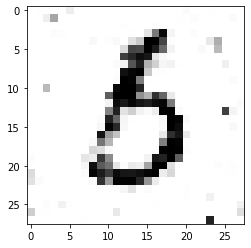

In [45]:
test_input = np.random.normal(0, 1, (1, 100))

reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Digits/Saved Model")
gen_image = (reconstructed_model.predict(test_input))

is_fake(discriminator, gen_image)

plt.imshow(gen_image.reshape((28, 28)), cmap='binary')

In [47]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Digits/Saved Model")

In [48]:
def generate_images_from_pretrained_model(model):
    test_input = np.random.normal(0, 1, (1, 100))

    gen_image = (model.predict(test_input))
    plt.imshow(gen_image.reshape((28, 28)), cmap='binary')

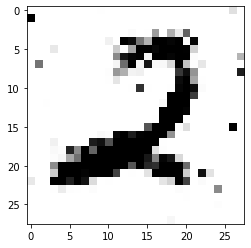